IMPORT PACKAGES

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import scrublet as scr
import joblib
from joblib import load
import sklearn
import xgboost as xgb

LOAD IN DATA

In [96]:
adata = sc.read_h5ad('/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/ML data/single cell profiling of LUAD/Lung_scVI_result_annotation_log1p_20230108.h5ad')

In [98]:
adata.obs["Anno1"]

AAACCTGAGTTGTCGT_LUNG_N01-0            NK
AAACCTGCACCGAAAG_LUNG_N01-0            NK
AAACCTGGTCAGAATA_LUNG_N01-0           CD8
AAACCTGTCTTCGGTC_LUNG_N01-0             B
AAACGGGAGTGGGATC_LUNG_N01-0       Myeloid
                                  ...    
55_GACTAACCGTGA-43             Epithelial
55_TCTCTCATACCT-43                      B
55_AGTACCAAAGCG-43                Myeloid
55_CCCATCCTACTT-43                      B
55_CCGTCTCTAGAC-43                   Treg
Name: Anno1, Length: 106829, dtype: category
Categories (10, object): ['B', 'CD4', 'CD8', 'Endothelial', ..., 'Mast', 'Myeloid', 'NK', 'Treg']

In [24]:
p5t2 = sc.read_h5ad('/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/ML data/NSLC data/p5t2.h5ad')
p5t2

AnnData object with n_obs × n_vars = 2427 × 72131
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent_mt', 'Patient', 'Gender', 'Subtype', 'Stage', 'seurat_clusters', 'Study', 'Cell_Cluster_level1', 'Cell_Cluster_level2', 'validation_original_annotation', 'id', 'predicted.celltypel1.score', 'predicted.celltypel1', 'predicted.celltypel2.score', 'predicted.celltypel2', 'Sample'

In [103]:
p5t2.obs['Cell_Cluster_level1'].value_counts()
p5t2_negative_control = p5t2[p5t2.obs['Cell_Cluster_level1'] != 'Cancer']
p5t2_negative_control.write_h5ad('/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/ML data/Intermediate/p5t2_negative_control.h5ad')

APP BACK END WITHOUT USER INPUT

In [45]:
# Run Scrublet
def detect_doublets(adata):
    # Ensure raw count matrix is used
    counts_matrix = adata.raw.X if adata.raw is not None else adata.X
    if hasattr(counts_matrix, "toarray"):
        counts_matrix = counts_matrix.toarray()

    scrub = scr.Scrublet(counts_matrix)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()

    adata.obs["doublet_score"] = doublet_scores
    adata.obs["predicted_doublet"] = predicted_doublets

    # Filter out doublets
    adata = adata[~predicted_doublets].copy()
    print(f"✅ Removed {np.sum(predicted_doublets)} predicted doublets.")
    return adata
    
# Function to calculate QC metrics and generate plots
def generate_qc_metrics(adata):
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # Identify mitochondrial genes
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    
    # Generate violin plots for QC metrics
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True, save="_qc_metrics.png", show = False)
    ## Maybe make this three separate figs 
    print("QC metrics calculated and violin plots saved as '_qc_metrics.png'")

# Preprocessing function
def preprocess_data(adata):
    generate_qc_metrics(adata)  # Calculate QC metrics before preprocessing
    
    sc.pp.filter_cells(adata, min_genes=200) #Changeable
    sc.pp.filter_genes(adata, min_cells= 3) #Changeable

    print("Filtering is done")

    # Identify mitochondrial genes
    adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")

    # Calculate QC metrics including mitochondrial percentage
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

    # Filter out cells with high mitochondrial content (usually > 5–10%)
    adata = adata[adata.obs["pct_counts_mt"] < 10].copy()

    print("Successfully filtered out cells w/>10% mitochondrial content")

    
    detect_doublets(adata)
    print("Successfully filtered out doublets")

    #comment out for running pre normalized data
    sc.pp.normalize_total(adata, target_sum= 1e4)
    sc.pp.log1p(adata)
    print("Normalization is done")


    sc.pp.highly_variable_genes(adata, n_top_genes= 2000) #Changeable
    print("Highly variable genes have been found")

    #make a copy of data before subsetting highly variable genes to feed to ML model for labeling
    ML_data = adata.copy()
    adata = adata[:, adata.var["highly_variable"]]

    # comment out when using pre-normalized data
    sc.pp.scale(adata, max_value= 10) #Download CSV of count matrix
    sc.pp.scale(ML_data, max_value=10) #Download CSV of count matrix


    return adata, ML_data

OLD ML FUNCTION(KEEP JUST IN CASE!)

In [166]:
# def predict_labels(adata, ML_data):
#     #subset highly variable genes used by model to predict labels
#     # HVG_list = pd.read_csv("/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/src/ML/HVG_model_gene_namesV4.csv")
#     # HVG_list = HVG_list.iloc[0].tolist()  # Convert the first row of the DataFrame to a list


#     # Load CSV
#     HVG_list = pd.read_csv("/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/src/ML/XGB_2kHVG_feature_importances.csv")

#     # Option 1: Get ALL genes in the "gene" column
#     HVG_list = HVG_list["gene"].tolist()

#     # # Option 2 (recommended): Keep only genes with non-zero importance
#     # HVG_list = HVG_list[HVG_list["importance"] > 0]["gene"].tolist()
        
#     intersection = ML_data.var_names.isin(HVG_list)

#     data_subet = ML_data[: , intersection]

#     # print(data_subet)

#     #prediction numerical label to words
#     label_dict = {
#     0: 'Non Epithelial',
#     1: 'Non Cancer Related',
#     2: 'Early (Stage I/II)',
#     3: 'Advanced (Stage III/IV)'}
    
#     #load in model
#     classifier = load('/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/src/ML/XGB_classifier_2kHVG.joblib')

#     #apply model to data
#     predictions = classifier.predict(data_subet.X)

#     #convert numerical labels to word predictions
#     word_labels = [label_dict[num_label] for num_label in predictions]

#     #create a new column in anndata object for model predictions
#     adata.obs["Classifier_predictions"] = word_labels

#     return adata

In [76]:
import pandas as pd
import numpy as np
from anndata import AnnData
from scipy.sparse import csr_matrix, hstack
from joblib import load

def align_anndata_to_genes(adata, expected_genes):
    """Ensure adata includes all genes in expected_genes, in correct order, with missing ones filled with zeros."""
    current_genes = adata.var_names
    present_genes = current_genes.intersection(expected_genes)
    missing_genes = [g for g in expected_genes if g not in current_genes]

    # Build sparse matrix for missing genes
    zero_matrix = csr_matrix((adata.n_obs, len(missing_genes)))

    # Combine existing and missing
    X_existing = adata[:, present_genes].X
    X_combined = hstack([X_existing, zero_matrix])

    # Reorder columns to match expected gene order
    all_genes = list(present_genes) + missing_genes
    gene_order_idx = [all_genes.index(g) for g in expected_genes]
    X_final = X_combined.tocsr()[:, gene_order_idx]

    # Return aligned AnnData
    aligned = AnnData(X=X_final, obs=adata.obs.copy())
    aligned.var_names = expected_genes
    
    return aligned, missing_genes


def predict_labels(adata, ML_data, confidence_threshold=0.9):
    # Load trained gene list (from feature importances CSV)
    # HVG_df = pd.read_csv("/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/src/ML/XGB_2kHVG_feature_importances.csv")
    
    HVG_list = pd.read_csv('/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/src/ML/XGB_classifier_V3_gene_names.csv').iloc[0].tolist()

    
    # # Keep only genes with non-zero importance
    # HVG_list = HVG_df[HVG_df["importance"] > 0]["gene"].tolist()
    
    # HVG_list = HVG_df["gene"].tolist()


    # Align ML_data to expected gene list
    ML_aligned, missing_genes = align_anndata_to_genes(ML_data, HVG_list)

    # Load XGBoost classifier
    # classifier = load('/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/src/ML/XGB_classifier_2kHVG.joblib')

    classifier = load('/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/src/ML/XGB_classifier_V3.joblib')


    #convert zeros from missing genes to np.nan
    X_input = ML_aligned.X.toarray() if hasattr(ML_aligned.X, "toarray") else ML_aligned.X
    
    missing_gene_indices = [ML_aligned.var_names.get_loc(gene) for gene in missing_genes]
    
    X_input[:, missing_gene_indices] = np.nan
    
    # Predict using aligned data
    predictions = classifier.predict(X_input)

    probability = classifier.predict_proba(X_input)

    confidence_scores = np.max(probability, axis=1)

    # Map numeric predictions to labels
    label_dict = {
        0: 'Non Epithelial',
        1: 'Non Cancer Related',
        2: 'Early (Stage I/II)',
        3: 'Advanced (Stage III/IV)'
    }

    raw_labels = [label_dict[p] for p in predictions]

    # Step 4: Apply confidence threshold
    final_labels = [
        raw_label if confidence >= confidence_threshold else "Unknown"
        for raw_label, confidence in zip(raw_labels, confidence_scores)
    ]
    # label_dict = {
    #     0: 'Non-Cancerous',
    #     1: 'Cancer',
    #     2: 'Cancer',
    #     3: 'Cancer'
    # }
    # word_labels = [label_dict[num_label] for num_label in predictions]

    # Add predictions to output AnnData object
    adata.obs["Classifier_predictions"] = raw_labels
    adata.obs["Classifier_prediction_probablility"] = confidence_scores
    adata.obs["Classifier_FINAL"] = final_labels

    return adata

In [ ]:
import scanpy as sc
import json
import os
import matplotlib.pyplot as plt
import pandas as pd 
import warnings
import shutil

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Function to perform clustering & generate UMAP
def generate_umap(adata):

    print("🔄 Running PCA & Neighbors...")
    sc.tl.pca(adata, svd_solver='arpack')  # Ensure PCA is computed
    sc.pp.neighbors(adata, n_neighbors=10,
                    n_pcs=40)
    
    print("✅ PCA & neighbors computed!")
    print("🔄 Running Leiden clustering...")
    
    sc.tl.leiden(
        adata,
        resolution=0.5,
        flavor="igraph",
        directed=False,
        n_iterations=2
    )

    print("✅ Leiden clustering complete!")

    print("🔄 Running UMAP...")
    sc.tl.umap(adata)
    print("✅ UMAP computation complete!")

    # # Generate and save UMAP plots
    # figures_dir = "figures"

    # # Recreate the directory
    # os.makedirs(figures_dir, exist_ok=True)

    # Default UMAP plots
    sc.pl.umap(adata, color=["leiden", "total_counts", "n_genes_by_counts"], wspace=0.4, save=f"_qc.png", show=False)
    sc.pl.umap(adata, color=adata.var_names[:5], wspace=0.4, save=f"_top5.png", show=False)

    print(f"✅ UMAP plots saved")

def user_umap(adata):
    requested_genes = ["IL-1"]
    print("received gene input")
    # Always treat as a list
    if isinstance(requested_genes, str):
        requested_genes = [requested_genes]

    # Strip and filter by genes that exist
    valid_genes = [gene.strip() for gene in requested_genes if gene.strip() in adata.var_names]
    if not valid_genes:
        print("❌ No valid genes found in the dataset for custom UMAP.")
        return
    # Plot valid genes
    sc.pl.umap(adata, color=valid_genes, save="_custom_gene.png", show=False)
    print(f"✅ User-defined UMAP generated for: {valid_genes}")

def prediction_umap(adata):
    sc.pl.umap(adata, color="Classifier_FINAL", save=f"ML_umap.png", show=True)
    print(f"ML-classified plot is done!")

# Function to perform differential gene expression analysis
def perform_differential_expression(adata):
    num_degs = 20
    sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon", use_raw=False)
    sc.pl.rank_genes_groups(adata, n_genes=num_degs, sharey=False, save =f".png", show=False )

    # Save DEGs to CSV    
    all_degs = []
    top10_degs = []

    for cluster in adata.obs["leiden"].cat.categories:
        df = sc.get.rank_genes_groups_df(adata, group=cluster)
        df["cluster"] = cluster
        all_degs.append(df)

        # Keep only top 10 for summary CSV
        top10_degs.append(df.head(10))

    # Concatenate all DEGs across clusters
    all_degs_df = pd.concat(all_degs)
    top10_degs_df = pd.concat(top10_degs)

    # Save full and top-10 DEG tables
    all_degs_df.to_csv("processed_data/all_degs.csv", index=False)
    top10_degs_df.to_csv("processed_data/top10_degs_by_cluster.csv", index=False)


    print("✅ Differential expression analysis completed and results saved.")



PRE PROCESS DATA FOR MODEL USE

In [ ]:
#Preprocess data
print("🔄 Running preprocessing...")
adata, ML_data = preprocess_data(adata)
print("✅ Preprocessing complete!")
adata

🔄 Running preprocessing...
QC metrics calculated and violin plots saved as '_qc_metrics.png'
Filtering is done
Successfully filtered out cells w/>10% mitochondrial content
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.42
Detected doublet rate = 1.0%
Estimated detectable doublet fraction = 69.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.4%
Elapsed time: 144.6 seconds
✅ Removed 1018 predicted doublets.
Successfully filtered out doublets
Highly variable genes have been found
✅ Preprocessing complete!


View of AnnData object with n_obs × n_vars = 106828 × 2000
    obs: 'type1', 'type2', 'sample', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'Anno1', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Anno1_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'rank_genes_groups', 'type1_colors', 'type2_colors'
    obsm: 'X_mde', 'X_scVI'

In [25]:
#Preprocess data
print("🔄 Running preprocessing...")
adata_p5t2, ML_data_p5t2 = preprocess_data(p5t2)
print("✅ Preprocessing complete!")


🔄 Running preprocessing...
QC metrics calculated and violin plots saved as '_qc_metrics.png'
Filtering is done
Successfully filtered out cells w/>10% mitochondrial content
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.64
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 3.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.3%
Elapsed time: 1.2 seconds
✅ Removed 2 predicted doublets.
Successfully filtered out doublets
Normalization is done
Highly variable genes have been found


/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


✅ Preprocessing complete!


In [48]:
#Preprocess data
print("🔄 Running preprocessing...")
p5t2_negatitve_adata, p5t2_negatitve_ML_data = preprocess_data(p5t2_negative)
print("✅ Preprocessing complete!")
p5t2_negatitve_adata

🔄 Running preprocessing...
QC metrics calculated and violin plots saved as '_qc_metrics.png'
Filtering is done
Successfully filtered out cells w/>10% mitochondrial content
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.52
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 6.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.9%
Elapsed time: 0.2 seconds
✅ Removed 2 predicted doublets.
Successfully filtered out doublets
Normalization is done
Highly variable genes have been found
✅ Preprocessing complete!


/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 1032 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent_mt', 'Patient', 'Gender', 'Subtype', 'Stage', 'seurat_clusters', 'Study', 'Cell_Cluster_level1', 'Cell_Cluster_level2', 'validation_original_annotation', 'id', 'predicted.celltypel1.score', 'predicted.celltypel1', 'predicted.celltypel2.score', 'predicted.celltypel2', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'log1p_mean_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

In [10]:
#Preprocess data
print("🔄 Running preprocessing...")
p5t2_positive_adata, p5t2_positive__ML_data = preprocess_data(p5t2_positive)
print("✅ Preprocessing complete!")
p5t2_positive_adata

🔄 Running preprocessing...
QC metrics calculated and violin plots saved as '_qc_metrics.png'
Filtering is done
Successfully filtered out cells w/>10% mitochondrial content
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.57
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 3.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 0.3 seconds
✅ Removed 0 predicted doublets.
Successfully filtered out doublets
Normalization is done
Highly variable genes have been found
✅ Preprocessing complete!


/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 1395 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent_mt', 'Patient', 'Gender', 'Subtype', 'Stage', 'seurat_clusters', 'Study', 'Cell_Cluster_level1', 'Cell_Cluster_level2', 'validation_original_annotation', 'id', 'predicted.celltypel1.score', 'predicted.celltypel1', 'predicted.celltypel2.score', 'predicted.celltypel2', 'Sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'log1p_mean_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

SPLIT LUAD DATA FROM PAPER 1 FOR MODEL TRAINING initial test for first model ever built 

In [129]:
# #split data into test and training sets

#subset barcodes for normal epithilial cells 
normal_Epithelial_barcodes = adata[(adata.obs['Anno1'].isin(["Epithelial"]) & (adata.obs['type2'] == "normal"))].obs.index.tolist()

#subset barcodes for early stage epithilial cells 
early_Epithelial_barcodes = adata[(adata.obs['Anno1'].isin(["Epithelial"]) & (adata.obs['type2'] == "early"))].obs.index.tolist()

#subset barcodes for advanced stage epithilial cells 
advanced_Epithelial_barcodes = adata[(adata.obs['Anno1'].isin(["Epithelial"]) & (adata.obs['type2'] == "advanced"))].obs.index.tolist()


import random

#set random seed
random.seed(17)

#subset training barcodes 
normal_Epithelial_barcodes_Train = random.sample(normal_Epithelial_barcodes, k = 2000)

early_Epithelial_barcodes_Train = random.sample(early_Epithelial_barcodes, k = 2000)

advanced_Epithelial_barcodes_Train = random.sample(advanced_Epithelial_barcodes, k = 2000)



#subset test barcodes
normal_Epithelial_barcodes_Test = list(set(normal_Epithelial_barcodes)-set(normal_Epithelial_barcodes_Train))

early_Epithelial_barcodes_Test = list(set(early_Epithelial_barcodes)-set(early_Epithelial_barcodes_Train))

advanced_Epithelial_barcodes_Test = list(set(advanced_Epithelial_barcodes)-set(advanced_Epithelial_barcodes_Train))


#create lsit of all barcodes
Train_barcodes_Epithelial = normal_Epithelial_barcodes_Train + early_Epithelial_barcodes_Train + advanced_Epithelial_barcodes_Train

Test_barcodes_Epithelial = normal_Epithelial_barcodes_Test + early_Epithelial_barcodes_Test + advanced_Epithelial_barcodes_Test


In [121]:
#subset non Epithelial cells in the dataset
non_Epithelial_barcodes = adata[~(adata.obs['Anno1'].isin(["Epithelial"]))].obs.index.tolist()

non_Epithelial_barcodes_Train = random.sample(non_Epithelial_barcodes, k = int((len(non_Epithelial_barcodes)/2)))

non_Epithelial_barcodes_Test = list(set(non_Epithelial_barcodes)-set(non_Epithelial_barcodes_Train))

In [130]:
#create trianing and test datasets

Train_barcodes = Train_barcodes_Epithelial + non_Epithelial_barcodes_Train

Train = adata[Train_barcodes, :]

Test_barcodes = Test_barcodes_Epithelial + non_Epithelial_barcodes_Test

Test = adata[Test_barcodes, :]

In [131]:
Test

View of AnnData object with n_obs × n_vars = 57333 × 2000
    obs: 'type1', 'type2', 'sample', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'Anno1', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Anno1_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'rank_genes_groups', 'type1_colors', 'type2_colors'
    obsm: 'X_mde', 'X_scVI'

In [132]:
#check if cell barcodes are the same for sanity check 
if pd.Series(Test.obs_names).equals(pd.Series(Train.obs_names)):
    print("barcodes are the same")
else:
    print("good")

good


In [133]:
#labeling function   
def label_cells(row):
    if row["Anno1"] == "Epithelial":
        if row["type2"] == "normal":
            return 1
        elif row["type2"] == "early":
            return 2
        elif row["type2"] == "advanced":
            return 3
    else:
        return 0

#y = _______.obs.apply(label_cells, axis=1)

TRIAN SCIKITLEARN RANDOM FOREST CLASSIFIERS

In [16]:
#train random forest classifier
from sklearn.ensemble import RandomForestClassifier
y = Train.obs.apply(label_cells, axis=1)

rfc = RandomForestClassifier(n_jobs = -1, n_estimators =100)
rfc.fit(Train.X, y)

RandomForestClassifier(n_jobs=-1)

In [17]:
predictions = rfc.predict(Test.X)

Test.obs["model_predict"] = predictions 
Test.obs

/var/folders/n1/zbp5__v174n08pvjknrstbt80000gp/T/ipykernel_34833/1105300860.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Test.obs["model_predict"] = predictions


,type1,type2,sample,batch,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,_scvi_batch,...,log1p_n_genes_by_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,log1p_total_counts_mt,doublet_score,predicted_doublet,model_predict
CTGTTTACAGTAGAGC_LUNG_N18-4,G131,normal,L5,4,917,917,1136.208252,28.808239,2.535472,4,...,6.822197,7.036332,12.840876,22.406640,37.142557,65.465376,3.394785,0.048148,False,1
GCTGCAGCAAGGCTCC_LUNG_N34-10,G131,normal,L11,10,1183,1183,1390.730103,22.348219,1.606941,10,...,7.076654,7.238303,9.915332,17.067383,28.432574,52.444094,3.150521,0.009763,False,1
TGACAACGTAACGTTC_LUNG_N28-7,G131,normal,L8,7,2938,2938,1330.451904,30.024567,2.256719,7,...,7.985825,7.194026,11.175409,19.010049,29.801951,48.257454,3.434779,0.005304,False,1
TGGGCGTGTTAAAGTG_LUNG_N30-8,G131,normal,L9,8,1556,1556,975.819397,27.040764,2.771083,8,...,7.350516,6.884302,14.371519,24.094603,36.475141,57.537870,3.333659,0.081533,False,1
CGGGTCACATATACGC_LUNG_N28-7,G131,normal,L8,7,2369,2369,1238.945190,28.098759,2.267958,7,...,7.770645,7.122822,12.181043,20.983204,32.360934,50.445998,3.370696,0.006398,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GACGCGTGTCTTTCAT_LUNG_T28-18,G131,advanced,L19,18,792,792,940.129517,25.914635,2.756496,18,...,6.675823,6.847081,18.234128,31.392474,47.207474,74.450879,3.292670,0.011986,False,0
41_AGTATTTTAGCT-36,G148,advanced,P28,36,710,710,1020.066589,27.997259,2.744650,30,...,6.566672,6.928603,15.409255,26.077888,42.878145,76.812685,3.367201,0.004116,False,0
CAGTAACCAGGACCCT_BRONCHO_58-25,G131,advanced,L26,25,791,791,1064.745605,25.646711,2.408717,25,...,6.674561,6.971430,14.019667,24.588269,40.480283,71.318498,3.282666,0.241339,False,0
TGAGCCGTCTATCCTA_LUNG_N30-8,G131,normal,L9,8,3728,3728,1424.704834,26.106201,1.832394,8,...,8.223895,7.262422,10.230309,17.675586,28.864793,47.338252,3.299762,0.035018,False,0


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     43737
           1       0.98      0.78      0.87      1394
           2       0.87      0.86      0.86      1700
           3       0.94      0.99      0.97     10502

    accuracy                           0.98     57333
   macro avg       0.95      0.91      0.92     57333
weighted avg       0.98      0.98      0.98     57333

Accuracy: 0.983726649573544


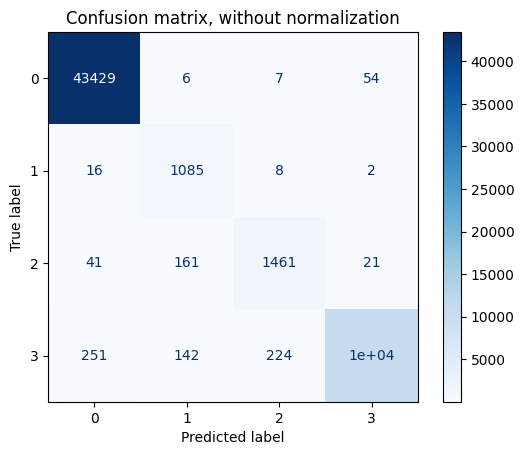

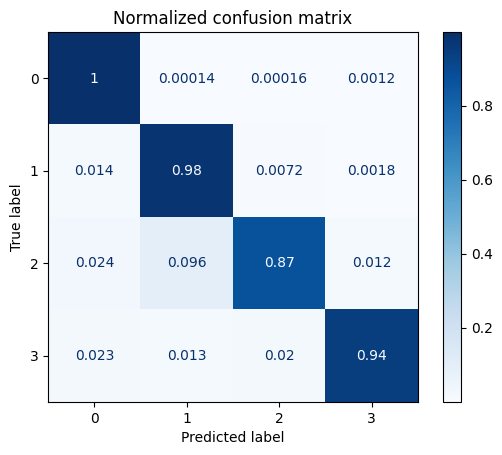

In [18]:
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

z = Test.obs.apply(label_cells, axis=1)

class_names = {0:'non-Epithelial', 1:"normal", 2:"early", 3:"advanced"}


print(classification_report(Test.obs["model_predict"], z))

print("Accuracy:", metrics.accuracy_score(Test.obs["model_predict"], z))

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        rfc,
        Test.X,
        z,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    # print(title)
    # print(disp.confusion_matrix)

plt.show()

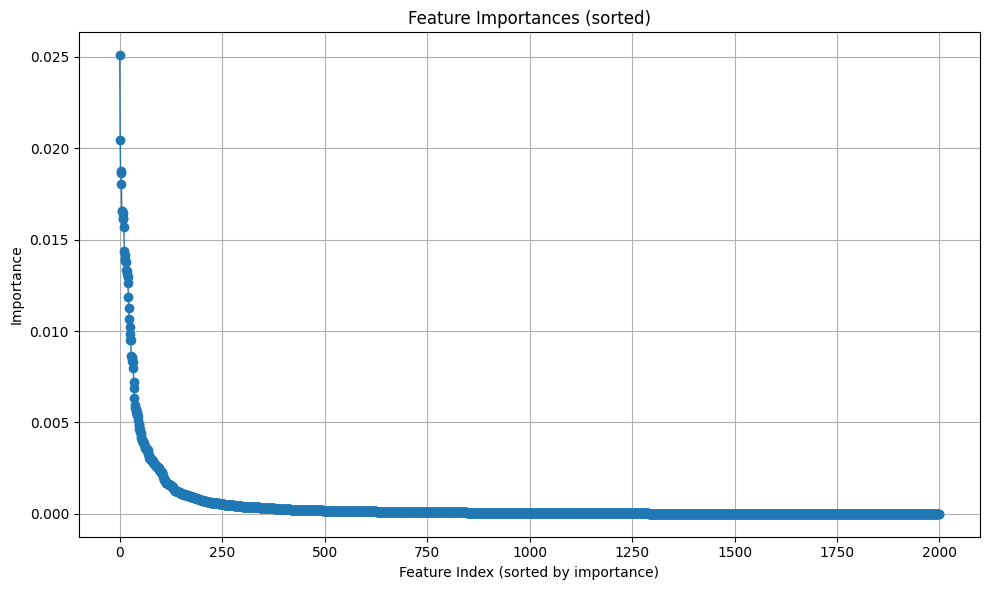

In [19]:
# Assuming your model is already trained
importances = rfc.feature_importances_
sorted_idx = np.argsort(importances)[::-1]  # Descending sort
sorted_importances = importances[sorted_idx]

plt.figure(figsize=(10, 6))
plt.plot(range(len(sorted_importances)), sorted_importances, marker='o', linewidth=1)
plt.title("Feature Importances (sorted)")
plt.xlabel("Feature Index (sorted by importance)")
plt.ylabel("Importance")
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
#subset top 500 features from model to train another model

# Map sorted indices to gene names from Train
sorted_gene_names = np.array(Train.var_names)[sorted_idx]

# Get top 500 genes
top_500_genes = sorted_gene_names[:500]

Train_top500 = Train[:, top_500_genes].copy()
Test_top500 = Test[:, top_500_genes].copy()

In [21]:
#train random forest classifier with the top 500 features from the first one
from sklearn.ensemble import RandomForestClassifier
y500 = Train_top500.obs.apply(label_cells, axis=1)

rfc_top_500_features = RandomForestClassifier(n_jobs = -1, n_estimators =100, random_state=10)
rfc_top_500_features.fit(Train_top500.X, y500)

RandomForestClassifier(n_jobs=-1, random_state=10)

In [22]:
predictions_500_features = rfc_top_500_features.predict(Test_top500.X)

Test_top500.obs["model_predict_500"] = predictions_500_features
Test_top500.obs

,type1,type2,sample,batch,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,_scvi_batch,...,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,log1p_total_counts_mt,doublet_score,predicted_doublet,model_predict,model_predict_500
CTGTTTACAGTAGAGC_LUNG_N18-4,G131,normal,L5,4,917,917,1136.208252,28.808239,2.535472,4,...,7.036332,12.840876,22.406640,37.142557,65.465376,3.394785,0.048148,False,1,1
GCTGCAGCAAGGCTCC_LUNG_N34-10,G131,normal,L11,10,1183,1183,1390.730103,22.348219,1.606941,10,...,7.238303,9.915332,17.067383,28.432574,52.444094,3.150521,0.009763,False,1,1
TGACAACGTAACGTTC_LUNG_N28-7,G131,normal,L8,7,2938,2938,1330.451904,30.024567,2.256719,7,...,7.194026,11.175409,19.010049,29.801951,48.257454,3.434779,0.005304,False,1,1
TGGGCGTGTTAAAGTG_LUNG_N30-8,G131,normal,L9,8,1556,1556,975.819397,27.040764,2.771083,8,...,6.884302,14.371519,24.094603,36.475141,57.537870,3.333659,0.081533,False,1,1
CGGGTCACATATACGC_LUNG_N28-7,G131,normal,L8,7,2369,2369,1238.945190,28.098759,2.267958,7,...,7.122822,12.181043,20.983204,32.360934,50.445998,3.370696,0.006398,False,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GACGCGTGTCTTTCAT_LUNG_T28-18,G131,advanced,L19,18,792,792,940.129517,25.914635,2.756496,18,...,6.847081,18.234128,31.392474,47.207474,74.450879,3.292670,0.011986,False,0,0
41_AGTATTTTAGCT-36,G148,advanced,P28,36,710,710,1020.066589,27.997259,2.744650,30,...,6.928603,15.409255,26.077888,42.878145,76.812685,3.367201,0.004116,False,0,0
CAGTAACCAGGACCCT_BRONCHO_58-25,G131,advanced,L26,25,791,791,1064.745605,25.646711,2.408717,25,...,6.971430,14.019667,24.588269,40.480283,71.318498,3.282666,0.241339,False,0,0
TGAGCCGTCTATCCTA_LUNG_N30-8,G131,normal,L9,8,3728,3728,1424.704834,26.106201,1.832394,8,...,7.262422,10.230309,17.675586,28.864793,47.338252,3.299762,0.035018,False,0,0


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     43695
           1       0.98      0.82      0.89      1335
           2       0.87      0.84      0.86      1751
           3       0.95      0.99      0.97     10552

    accuracy                           0.98     57333
   macro avg       0.95      0.91      0.93     57333
weighted avg       0.98      0.98      0.98     57333

Accuracy: 0.9847033994383688


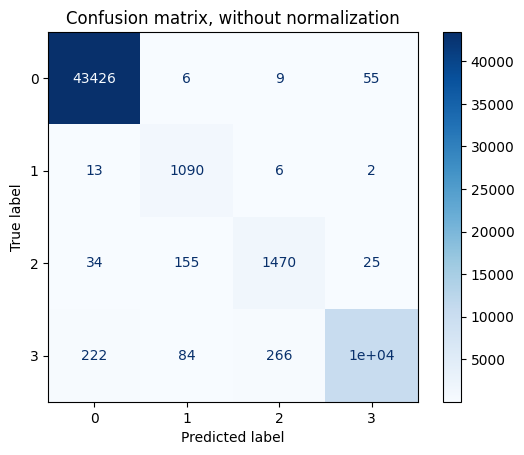

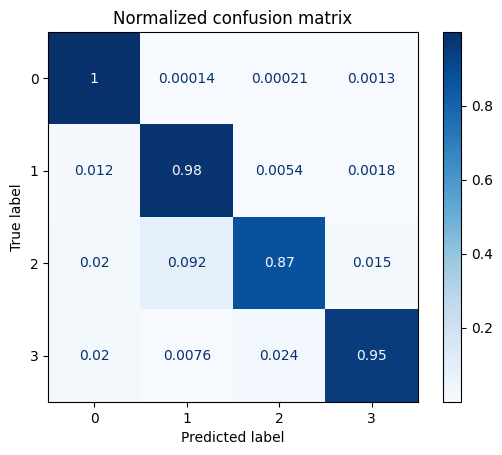

In [23]:
z_500 = Test_top500.obs.apply(label_cells, axis=1)

class_names = {0:'non-Epithelial', 1:"normal", 2:"early", 3:"advanced"}


print(classification_report(Test_top500.obs["model_predict_500"], z_500))

print("Accuracy:", metrics.accuracy_score(Test_top500.obs["model_predict_500"], z_500))

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        rfc_top_500_features,
        Test_top500.X,
        z_500,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    # print(title)
    # print(disp.confusion_matrix)

plt.show()

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     43693
           1       0.98      0.83      0.90      1308
           2       0.88      0.83      0.85      1790
           3       0.95      0.99      0.97     10542

    accuracy                           0.98     57333
   macro avg       0.95      0.91      0.93     57333
weighted avg       0.98      0.98      0.98     57333

Accuracy: 0.9844940958959064


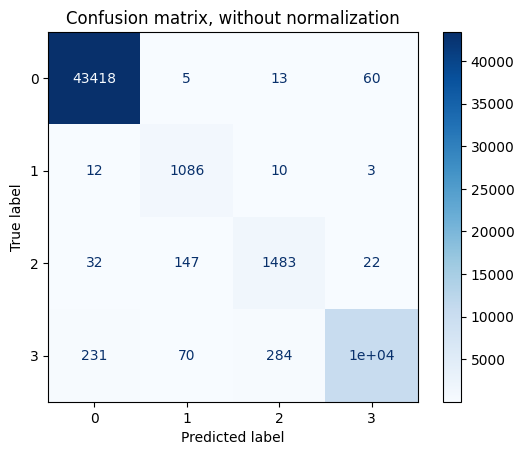

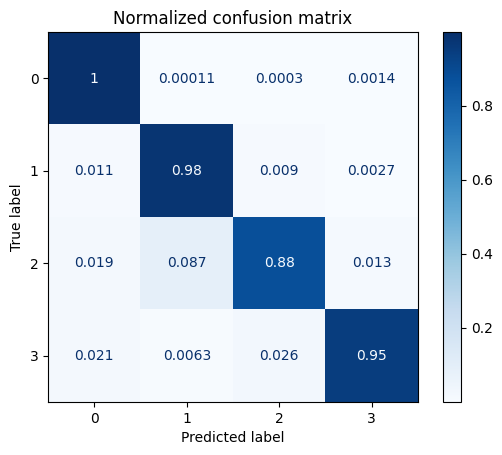

In [24]:
#subset top 250 features from model and train another model + assess metrics

# Get top 250 genes
top_250_genes = sorted_gene_names[:250]

Train_top250 = Train[:, top_250_genes].copy()
Test_top250 = Test[:, top_250_genes].copy()



#train random forest classifier with the top 250 features from the first one
y250 = Train_top250.obs.apply(label_cells, axis=1)

rfc_top_250_features = RandomForestClassifier(n_jobs = -1, n_estimators =100, random_state=10)
rfc_top_250_features.fit(Train_top250.X, y250)


predictions_250_features = rfc_top_250_features.predict(Test_top250.X)

Test_top250.obs["model_predict_250"] = predictions_250_features


#assess metrics for 250 feature model

z_250 = Test_top250.obs.apply(label_cells, axis=1)

class_names = {0:'non-Epithelial', 1:"normal", 2:"early", 3:"advanced"}


print(classification_report(Test_top250.obs["model_predict_250"], z_250))

print("Accuracy:", metrics.accuracy_score(Test_top250.obs["model_predict_250"], z_250))

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        rfc_top_250_features,
        Test_top250.X,
        z_250,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    # print(title)
    # print(disp.confusion_matrix)

plt.show()


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     43699
           1       0.98      0.82      0.89      1325
           2       0.87      0.82      0.85      1776
           3       0.94      0.99      0.97     10533

    accuracy                           0.98     57333
   macro avg       0.95      0.91      0.92     57333
weighted avg       0.98      0.98      0.98     57333

Accuracy: 0.9833778103361066


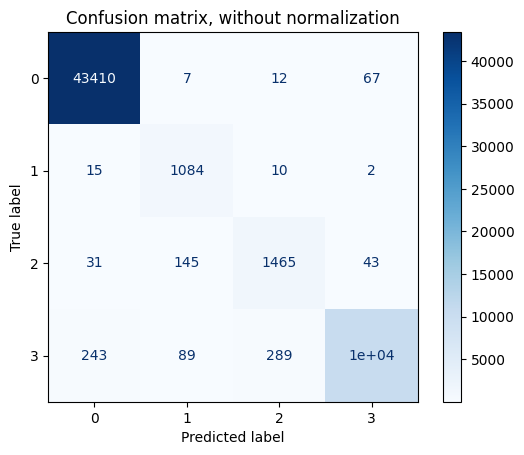

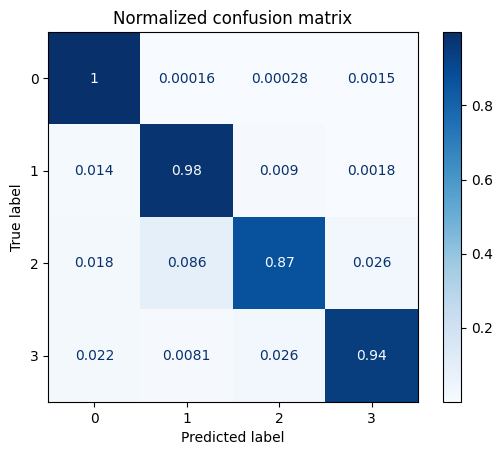

In [25]:
#subset top 250 features from model and train another model + assess metrics

# Get top 250 genes
top_125_genes = sorted_gene_names[:125]

Train_top125 = Train[:, top_125_genes].copy()
Test_top125 = Test[:, top_125_genes].copy()



#train random forest classifier with the top 250 features from the first one
y125 = Train_top125.obs.apply(label_cells, axis=1)

rfc_top_125_features = RandomForestClassifier(n_jobs = -1, n_estimators =100, random_state=10)
rfc_top_125_features.fit(Train_top125.X, y125)


predictions_125_features = rfc_top_125_features.predict(Test_top125.X)

Test_top125.obs["model_predict_125"] = predictions_125_features


#assess metrics for 250 feature model

z_125 = Test_top125.obs.apply(label_cells, axis=1)

class_names = {0:'non-Epithelial', 1:"normal", 2:"early", 3:"advanced"}


print(classification_report(Test_top125.obs["model_predict_125"], z_125))

print("Accuracy:", metrics.accuracy_score(Test_top125.obs["model_predict_125"], z_125))

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        rfc_top_125_features,
        Test_top125.X,
        z_125,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    # print(title)
    # print(disp.confusion_matrix)

plt.show()


In [26]:
from joblib import dump

dump(rfc_top_125_features, '/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/src/ML/classifierV4.joblib')

['/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/src/ML/classifierV4.joblib']

In [27]:
feature_names = Train_top125.var_names.tolist()

df = pd.DataFrame(feature_names, columns=['GeneName']).T

df.to_csv('/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/src/ML/HVG_model_gene_namesV4.csv', header = True, index=False)

GENERATE XGB MODELS AND PRUNE FEATURES FOR OPTIMAL USE

/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [13:00:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

/var/folders/n1/zbp5__v174n08pvjknrstbt80000gp/T/ipykernel_58061/3600996274.py:31: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Test.obs["XGB_model_predict"] = XGB_predictions


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     43698
           1       0.96      0.87      0.92      1225
           2       0.91      0.83      0.87      1845
           3       0.95      1.00      0.97     10565

    accuracy                           0.99     57333
   macro avg       0.96      0.92      0.94     57333
weighted avg       0.99      0.99      0.99     57333

Accuracy: 0.986709225053634


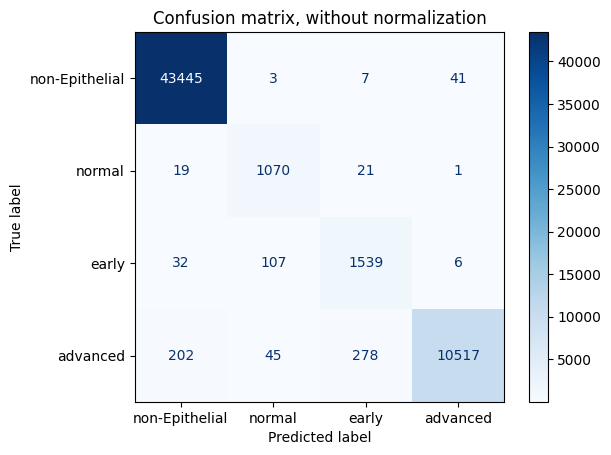

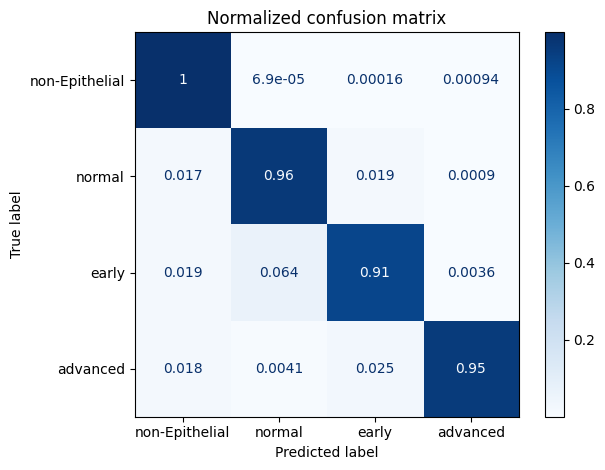

In [134]:
#generate XGBoost model for best fit model on 2000 HVG features + assess metrics

import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_XGB = Train.obs.apply(label_cells, axis=1)

# Ensure X is a dense array
X_train = Train.X.toarray() if hasattr(Train.X, "toarray") else Train.X

# Ensure y is a 1D NumPy array
y_train = np.array(y_XGB).ravel()  # ravel flattens it safely


# Train the classifier
XGB_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    missing=np.nan,  # <- tells model to expect missing values
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method="hist"
)
XGB_model.fit(X_train, y_train)


XGB_predictions = XGB_model.predict(Test.X)

Test.obs["XGB_model_predict"] = XGB_predictions


#assess metrics 

z_XGB = Test.obs.apply(label_cells, axis=1)

class_names = {0:'non-Epithelial', 1:"normal", 2:"early", 3:"advanced"}



print(classification_report(Test.obs["XGB_model_predict"], z_XGB))

print("Accuracy:", sklearn.metrics.accuracy_score(Test.obs["XGB_model_predict"], z_XGB))

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true=z_XGB,
        y_pred=Test.obs["XGB_model_predict"],
        display_labels=list(class_names.values()),
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

plt.tight_layout()
plt.show()


In [40]:
from joblib import dump

dump(XGB_model, '/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/src/ML/XGB_classifier_2kHVG.joblib')

['/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/src/ML/XGB_classifier_2kHVG.joblib']

In [ ]:
#plot the importance of features in the model to detetmine pruning paramaters for model weights

# XGB_model_2k_HVG = load('/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/src/ML/XGB_classifier_2kHVG.joblib')

#extract feature names and thier importances from the model and training dataset
XGB_model_2k_HVG = XGB_model
importances = XGB_model_2k_HVG.feature_importances_
XGB_model_2k_HVG_feature_names = Train.var_names

#create a dataframe with the feature names and thier importances as columns 
feature_importances_df = pd.DataFrame({
    'feature': XGB_model_2k_HVG_feature_names,
    'importance': importances

})


#sort by importance of feature in descending order 
sorted_feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

#remove features with zero importance
sorted_feature_importances_df = sorted_feature_importances_df[sorted_feature_importances_df['importance']> 0] 


# filter features by thresholding importance values
threshold = 0.0015
filtered_feature_importances_df = sorted_feature_importances_df[sorted_feature_importances_df['importance'] > threshold]
# filtered_feature_importances_df = filtered_feature_importances_df.sort_values('importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(filtered_feature_importances_df['feature'], filtered_feature_importances_df['importance'])
plt.title(f"Feature Importances Above {threshold} Threshold")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=90)  # Rotate feature names for better visibility if needed
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(len(filtered_feature_importances_df['feature'])), filtered_feature_importances_df['importance'], marker='o', linewidth=1)
plt.title("Feature Importances (sorted)")
plt.xlabel("Feature Index (sorted by importance)")
plt.ylabel("Importance")
plt.grid(True)
plt.tight_layout()
plt.show()

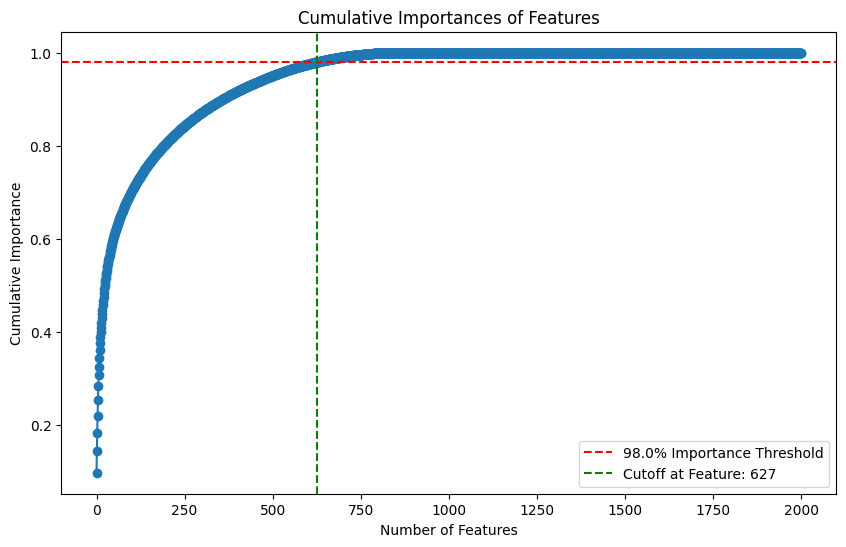

In [154]:
#get cumulative sum of feature imprtances to determine the features that explain 95% of the data 

cumulative_importances = np.cumsum(sorted_importances)
cumulative_threshold = 0.98
features_needed = np.where(cumulative_importances > cumulative_threshold)[0][0] + 1

plt.figure(figsize=(10, 6))
plt.plot(cumulative_importances, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Importances of Features')
plt.axhline(y=cumulative_threshold, color='r', linestyle='--', label=f'{cumulative_threshold*100}% Importance Threshold')
plt.axvline(x=features_needed - 1, color='g', linestyle='--', label=f'Cutoff at Feature: {features_needed}')
plt.legend()
plt.show()

In [ ]:
XGB_model_2k_HVG_95percent_features = sorted_feature_importances_df[:627]

genes_95percent = XGB_model_2k_HVG_95percent_features["feature"].tolist()

genes_95percent

Test_95percent_genes = Test[:Tes.var_names.isin()]




['FAM83A',
 'SFTPB',
 'EPCAM',
 'CYB5A',
 'KRT7',
 'MUC1',
 'WFDC2',
 'KRT19',
 'C20orf85',
 'CEACAM6',
 'CHI3L1',
 'CYP4B1',
 'ELF3',
 'LY6D',
 'C9orf24',
 'S100A14',
 'HPGD',
 'AGR2',
 'DSP',
 'TMC5',
 'AQP5',
 'S100P',
 'MEG3',
 'KRT8',
 'MT-ATP8',
 'SFTA2',
 'GPR183',
 'SLPI',
 'PRAME',
 'DHRS2',
 'ZFAS1',
 'AGER',
 'GGTLC1',
 'KRT18',
 'PITX1',
 'LTB',
 'CLDN4',
 'SLA',
 'LAMP3',
 'SFTPC',
 'TFPI2',
 'C1orf194',
 'IGKC',
 'TPPP3',
 'A2M',
 'HP',
 'FXYD3',
 'CDKN2A',
 'MS4A8',
 'GNG11',
 'ISLR',
 'MS4A7',
 'TM4SF4',
 'SCGB1A1',
 'HCK',
 'SAA1',
 'VIM',
 'PGC',
 'CCL5',
 'GAPDH',
 'PLAT',
 'COL1A2',
 'EEF1A1',
 'TCF4',
 'CLDN6',
 'CD24',
 'CEACAM5',
 'TACSTD2',
 'SFTPA1',
 'CD84',
 'NECAB1',
 'PSCA',
 'EMP2',
 'FGG',
 'AGR3',
 'CDA',
 'TNFSF10',
 'SPARC',
 'MDFI',
 'TPSB2',
 'BTG1',
 'CPM',
 'S100A6',
 'CLDN18',
 'CD247',
 'ITLN2',
 'GKN2',
 'CD6',
 'CD3G',
 'KRT6A',
 'MS4A6A',
 'CXCL14',
 'CCDC146',
 'SCGB3A1',
 'TMEM176A',
 'CD2AP',
 'ABCA1',
 'MFAP4',
 'SNCG',
 'FGL2',
 'ADIRF',


In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_XGB = Train.obs.apply(label_cells, axis=1)

# Ensure X is a dense array
X_train = Train.X.toarray() if hasattr(Train.X, "toarray") else Train.X

# Ensure y is a 1D NumPy array
y_train = np.array(y_XGB).ravel()  # ravel flattens it safely


# Train the classifier
XGB_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    missing=np.nan,  # <- tells model to expect missing values
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method="hist"
)
XGB_model.fit(X_train, y_train)


XGB_predictions = XGB_model.predict(Test.X)

Test.obs["XGB_model_predict"] = XGB_predictions


#assess metrics 

z_XGB = Test.obs.apply(label_cells, axis=1)

class_names = {0:'non-Epithelial', 1:"normal", 2:"early", 3:"advanced"}



print(classification_report(Test.obs["XGB_model_predict"], z_XGB))

print("Accuracy:", sklearn.metrics.accuracy_score(Test.obs["XGB_model_predict"], z_XGB))

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true=z_XGB,
        y_pred=Test.obs["XGB_model_predict"],
        display_labels=list(class_names.values()),
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

plt.tight_layout()
plt.show()

In [52]:
np.sum(adata.X, axis = 0)

array([1.6844871e+04, 7.2092877e+02, 7.3613647e+03, ..., 3.4894638e+02,
       1.6098434e+01, 1.6175733e+04], dtype=float32)

In [53]:
gene_names = adata.var_names
gene_names = set(gene_names)


In [54]:
HVG_list = pd.read_csv("/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/src/ML/HVG_model_gene_namesV2.csv")
HVG_list = HVG_list.iloc[0].tolist()  # Convert the first row of the DataFrame to a list
HVG_list = set(HVG_list)

In [55]:
intersection_set = len(gene_names & HVG_list)
intersection_set

1995

Test workflow on p5t2 data using integrated workflow 

In [26]:

# Generate UMAPs and perform clustering
generate_umap(adata_p5t2)

🔄 Running PCA & Neighbors...
✅ PCA & neighbors computed!
🔄 Running Leiden clustering...
✅ Leiden clustering complete!
🔄 Running UMAP...
✅ UMAP computation complete!
✅ UMAP plots saved


In [27]:
user_umap(adata_p5t2)

received gene input
❌ No valid genes found in the dataset for custom UMAP.


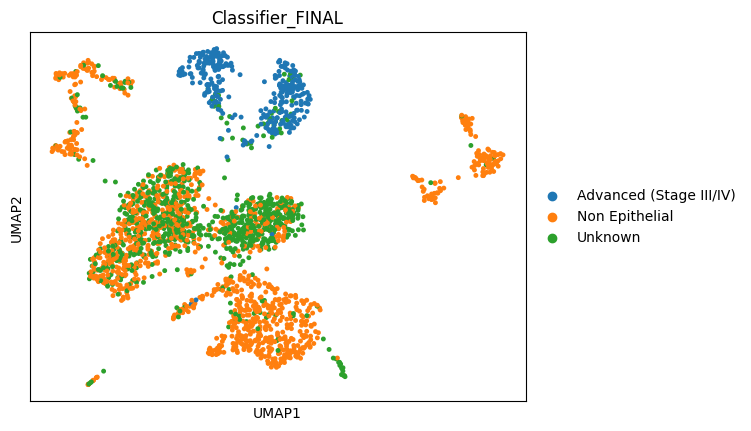

ML-classified plot is done!


In [28]:
#generate model cell type predictions
adata_p5t2 = predict_labels(adata_p5t2, ML_data_p5t2)

prediction_umap(adata_p5t2)

In [32]:
print(adata_p5t2.obs.groupby(['Cell_Cluster_level1', "Stage"]).size())

adata_p5t2.obs.groupby(["Classifier_FINAL"]).size()



Cell_Cluster_level1  Stage
B                    III      365
Cancer               III      364
Ciliated             III        5
Endothelial          III       59
Fibroblasts          III      107
Mast                 III       15
Myeloid              III      510
Plasma               III      127
T                    III      875
dtype: int64


/var/folders/n1/zbp5__v174n08pvjknrstbt80000gp/T/ipykernel_28511/788870086.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(adata_p5t2.obs.groupby(['Cell_Cluster_level1', "Stage"]).size())
/var/folders/n1/zbp5__v174n08pvjknrstbt80000gp/T/ipykernel_28511/788870086.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_p5t2.obs.groupby(["Classifier_FINAL"]).size()


Classifier_FINAL
Advanced (Stage III/IV)     329
Non Epithelial             1232
Unknown                     866
dtype: int64

In [77]:
print("🔄 Running preprocessing...")
p5t2_neg_adata, p5t2_neg_ML_data = preprocess_data(p5t2_neg)
print("✅ Preprocessing complete!")
p5t2_neg_adata

🔄 Running preprocessing...
QC metrics calculated and violin plots saved as '_qc_metrics.png'
Filtering is done
Successfully filtered out cells w/>10% mitochondrial content
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.62
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 5.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.0%
Elapsed time: 0.7 seconds
✅ Removed 2 predicted doublets.
Successfully filtered out doublets
Normalization is done
Highly variable genes have been found
✅ Preprocessing complete!


/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 2062 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent_mt', 'Patient', 'Gender', 'Subtype', 'Stage', 'seurat_clusters', 'Study', 'Cell_Cluster_level1', 'Cell_Cluster_level2', 'validation_original_annotation', 'id', 'predicted.celltypel1.score', 'predicted.celltypel1', 'predicted.celltypel2.score', 'predicted.celltypel2', 'Sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'log1p_mean_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

🔄 Running PCA & Neighbors...
✅ PCA & neighbors computed!
🔄 Running Leiden clustering...
✅ Leiden clustering complete!
🔄 Running UMAP...
✅ UMAP computation complete!
✅ UMAP plots saved
received gene input
❌ No valid genes found in the dataset for custom UMAP.


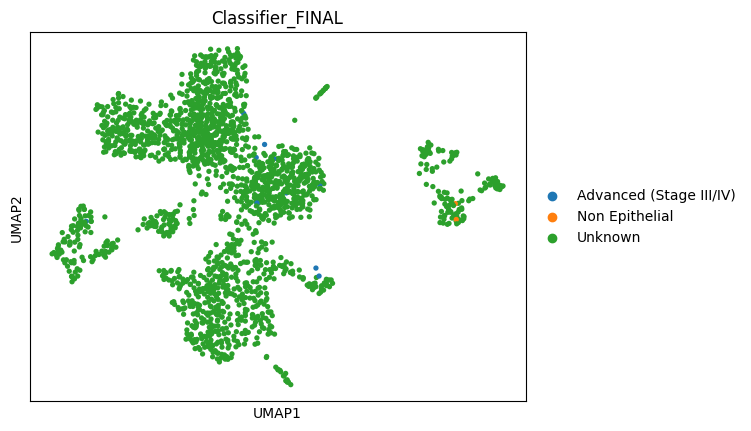

ML-classified plot is done!


In [78]:
generate_umap(p5t2_neg_adata)

user_umap(p5t2_neg_adata)

#generate model cell type predictions
p5t2_neg_adata = predict_labels(p5t2_neg_adata, p5t2_neg_ML_data)

prediction_umap(p5t2_neg_adata)

In [84]:
# # p5t2_negatitve_adata.obs["Classifier_FINAL"]
# p5t2_neg_adata.obs["Classifier_FINAL"].value_counts()

p5t2_neg_adata.obs['Cell_Cluster_level1'].value_counts()


Cell_Cluster_level1
T              875
Myeloid        509
B              365
Plasma         127
Fibroblasts    107
Endothelial     59
Mast            15
Ciliated         5
Name: count, dtype: int64

                         precision    recall  f1-score   support

Advanced (Stage III/IV)       0.00      0.00      0.00         0
         Non Epithelial       1.00      0.17      0.29        12
                Unknown       1.00      1.00      1.00      2050

               accuracy                           1.00      2062
              macro avg       0.67      0.39      0.43      2062
           weighted avg       1.00      1.00      1.00      2062

Accuracy: 0.9951503394762367


/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (5).

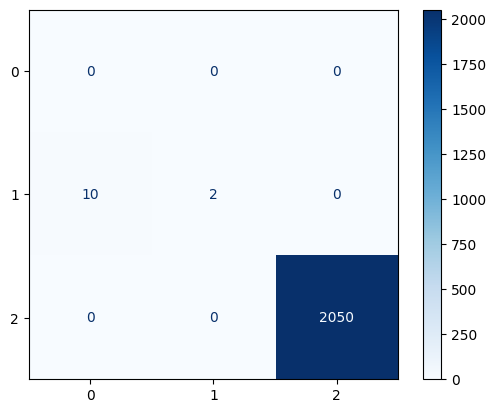

In [95]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
#assess metrics 

# def label_cells_p5t2(row):
#     if row['Cell_Cluster_level1'] == "Cancer":
#         if row["Stage"] == "I":
#             return "Early (Stage I/II)"
#         elif row["Stage"] == "II":
#             return "Early (Stage I/II)"
#         elif row["Stage"] == "III":
#             return "Advanced (Stage III/IV)"
#     elif row['Cell_Cluster_level1'] != "Cancer":
#         if row["Classifier_FINAL"] == "Unknown":
#             return "Unknown"
#         else:
#             return "Non Epithelial"
        

def label_cells_p5t2(row):
    # Check if the cell is part of "Cancer"
    if row["Classifier_FINAL"] == "Unknown":
            return "Unknown"
    if row['Cell_Cluster_level1'] == "Cancer":
        # Handle "Early (Stage I/II)" cases
        if row["Stage"] == "I" or row["Stage"] == "II":
            return "Early (Stage I/II)"
        # Handle "Advanced (Stage III/IV)" cases
        elif row["Stage"] == "III" or row["Stage"] == "IV":
            return "Advanced (Stage III/IV)"
    # Handle non-cancer cells
    elif row['Cell_Cluster_level1'] != "Cancer":
        if row["Classifier_FINAL"] == "Unknown":
            return "Unknown"
        else:
            return "Non Epithelial"
    
z_XGB = p5t2_neg_adata.obs.apply(label_cells_p5t2, axis=1)

class_names = ['Non Epithelial', 'Non Cancer Related','Early (Stage I/II)','Advanced (Stage III/IV)', 'Unknown']



print(classification_report(z_XGB, p5t2_neg_adata.obs['Classifier_FINAL']))

print("Accuracy:", sklearn.metrics.accuracy_score(p5t2_neg_adata.obs['Classifier_FINAL'], z_XGB))

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true=z_XGB,
        y_pred=p5t2_neg_adata.obs['Classifier_FINAL'],
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

plt.tight_layout()
plt.show()

In [94]:
np.unique(z_XGB.values)
print(p5t2_neg_adata.obs['Classifier_FINAL'].value_counts())


Classifier_FINAL
Unknown                    2050
Advanced (Stage III/IV)      10
Non Epithelial                2
Name: count, dtype: int64


🔄 Running PCA & Neighbors...
✅ PCA & neighbors computed!
🔄 Running Leiden clustering...
✅ Leiden clustering complete!
🔄 Running UMAP...
✅ UMAP computation complete!
✅ UMAP plots saved
received gene input
❌ No valid genes found in the dataset for custom UMAP.


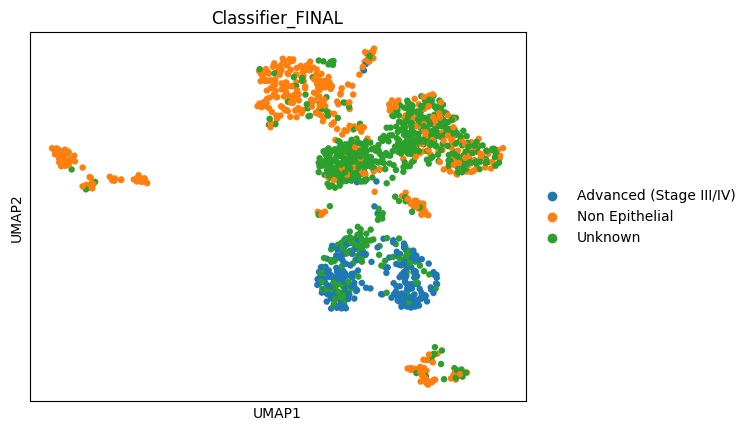

ML-classified plot is done!


In [101]:
generate_umap(p5t2_positive_adata)

user_umap(p5t2_positive_adata)

#generate model cell type predictions
p5t2_negatitve_adata = predict_labels(p5t2_positive_adata, p5t2_positive__ML_data)

prediction_umap(p5t2_positive_adata)

                         precision    recall  f1-score   support

Advanced (Stage III/IV)       1.00      0.99      1.00       242
         Non Epithelial       1.00      1.00      1.00       474
                Unknown       1.00      1.00      1.00       679

               accuracy                           1.00      1395
              macro avg       1.00      1.00      1.00      1395
           weighted avg       1.00      1.00      1.00      1395

Accuracy: 0.9985663082437276


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (5).

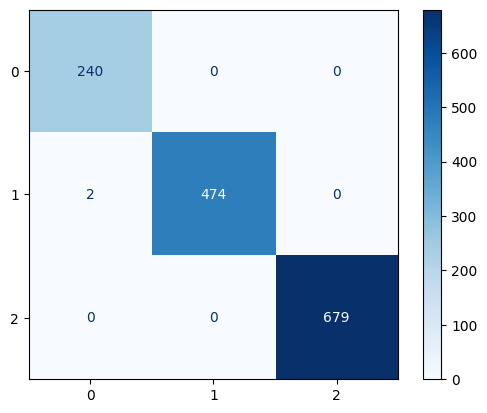

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
#assess metrics 

# def label_cells_p5t2(row):
#     if row['Cell_Cluster_level1'] == "Cancer":
#         if row["Stage"] == "I":
#             return "Early (Stage I/II)"
#         elif row["Stage"] == "II":
#             return "Early (Stage I/II)"
#         elif row["Stage"] == "III":
#             return "Advanced (Stage III/IV)"
#     elif row['Cell_Cluster_level1'] != "Cancer":
#         if row["Classifier_FINAL"] == "Unknown":
#             return "Unknown"
#         else:
#             return "Non Epithelial"
        

def label_cells_p5t2(row):
    # Check if the cell is part of "Cancer"
    if row["Classifier_FINAL"] == "Unknown":
            return "Unknown"
    if row['Cell_Cluster_level1'] == "Cancer":
        # Handle "Early (Stage I/II)" cases
        if row["Stage"] == "I" or row["Stage"] == "II":
            return "Early (Stage I/II)"
        # Handle "Advanced (Stage III/IV)" cases
        elif row["Stage"] == "III" or row["Stage"] == "IV":
            return "Advanced (Stage III/IV)"
    # Handle non-cancer cells
    elif row['Cell_Cluster_level1'] != "Cancer":
        if row["Classifier_FINAL"] == "Unknown":
            return "Unknown"
        else:
            return "Non Epithelial"
    
z_XGB = p5t2_positive_adata.obs.apply(label_cells_p5t2, axis=1)

class_names = ['Non Epithelial', 'Non Cancer Related','Early (Stage I/II)','Advanced (Stage III/IV)', 'Unknown']



print(classification_report(z_XGB, p5t2_positive_adata.obs['Classifier_FINAL']))

print("Accuracy:", sklearn.metrics.accuracy_score(p5t2_positive_adata.obs['Classifier_FINAL'], z_XGB))

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true=z_XGB,
        y_pred=p5t2_positive_adata.obs['Classifier_FINAL'],
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

plt.tight_layout()
plt.show()

In [58]:
# p5t2_positive_adata.obs[['Cell_Cluster_level1', "Classifier_FINAL"]].value_counts()
# p5t2_positive_classification = p5t2_positive_adata[p5t2_positive_adata.obs["Classifier_FINAL"] != "Unknown", :]
# p5t2_positive_classification
p5t2_positive_adata.obs["Classifier_FINAL"].value_counts()
# p5t2_negatitve_adata.obs["Classifier_FINAL"].value_counts()



Classifier_FINAL
Non Epithelial             647
Unknown                    450
Advanced (Stage III/IV)    298
Name: count, dtype: int64

In [52]:
# adata_p5t2.obs.groupby(['Cell_Cluster_level1', 'Stage']).size()
adata_p5t2.obs.groupby(["Classifier_predictions"]).size()

/var/folders/n1/zbp5__v174n08pvjknrstbt80000gp/T/ipykernel_58061/887524957.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_p5t2.obs.groupby(["Classifier_predictions"]).size()


Classifier_predictions
Advanced (Stage III/IV)      59
Early (Stage I/II)            9
Non Cancer Related           16
Non Epithelial             2343
dtype: int64

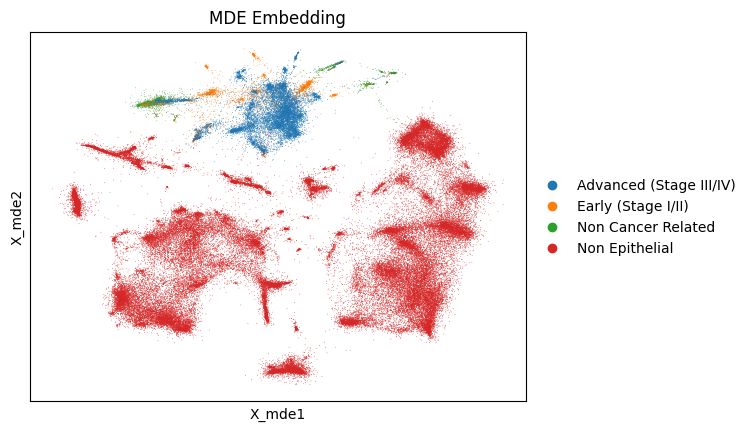

In [50]:
#view umap
sc.pl.embedding(adata, basis='X_mde', color= "Classifier_predictions", title='MDE Embedding')

np.nan and new training XGbost model

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Assume you already have your AnnData object:
# adata (with .X = features, .obs['labels'] = your target labels)

# Step 1: Extract your labels
y = adata.obs["numerical_labels_groundtruth"]    # or whatever your label column is

# Step 2: Stratified Train/Test Split based on cells
train_idx, test_idx = train_test_split(
    adata.obs_names,       # split based on cell names
    test_size=0.15,        # 15% test set
    stratify=y,            # maintain class proportions
    random_state=42
)

# Step 3: Create Train and Test AnnData objects
adata_train = adata[train_idx, :].copy()
adata_test = adata[test_idx, :].copy()

print(f"Train size: {adata_train.n_obs} samples")
print(f"Test size: {adata_test.n_obs} samples")

# Step 4: Prepare X_train, y_train, X_test, y_test
X_train = adata_train.X.toarray() if not isinstance(adata_train.X, np.ndarray) else adata_train.X
y_train = adata_train.obs["numerical_labels_groundtruth"].values

X_test = adata_test.X.toarray() if not isinstance(adata_test.X, np.ndarray) else adata_test.X
y_test = adata_test.obs["numerical_labels_groundtruth"].values

# Step 5: Compute Automatic Class Weights
classes = np.unique(y_train)
class_weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, class_weights_array))

print("Class weights:", class_weights)

# Step 6: Build sample weights for training samples
sample_weights = np.array([class_weights[label] for label in y_train])


# Train the classifier
XGB_model = xgb.XGBClassifier(
    objective='multi:softprob',     # Multiclass
    num_class=len(classes),         # Number of classes
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    missing=np.nan,  # <- tells model to expect missing values
    use_label_encoder=False,
    random_state=17,
    eval_metric='mlogloss',
    tree_method="hist"
)
XGB_model.fit(X_train, y_train)

# Step 8: Train the model
XGB_model.fit(
    X_train, y_train,
    sample_weight=sample_weights
)

# Step 9: Predict on test set
y_pred = XGB_model.predict(X_test)

# Step 10: Evaluate
print(classification_report(y_test, y_pred, target_names=['0', '1', '2', '3']))


Train size: 90803 samples
Test size: 16025 samples
Class weights: {np.int64(0): np.float64(0.30700751940710286), np.int64(1): np.float64(8.585760211800302), np.int64(2): np.float64(7.250319386777387), np.int64(3): np.float64(2.0476952913584703)}


/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:09:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:10:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13049
           1       0.94      0.98      0.96       467
           2       0.97      0.94      0.95       553
           3       0.99      0.99      0.99      1956

    accuracy                           0.99     16025
   macro avg       0.97      0.98      0.98     16025
weighted avg       0.99      0.99      0.99     16025



In [227]:
from joblib import dump

dump(XGB_model, "/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/src/ML/processed scvi data/XGB_classifier_V3.joblib")

['/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/src/ML/processed scvi data/XGB_classifier_V3.joblib']

In [246]:
gene_names = adata_train.var_names
gene_names = pd.DataFrame(gene_names, columns=['GeneName']).T
gene_names.to_csv("/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/src/ML/processed scvi data/XGB_classifier_V3_gene_names.csv", index = False)

In [286]:
ML_data_p5t2


AnnData object with n_obs × n_vars = 2427 × 19958
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent_mt', 'Patient', 'Gender', 'Subtype', 'Stage', 'seurat_clusters', 'Study', 'Cell_Cluster_level1', 'Cell_Cluster_level2', 'validation_original_annotation', 'id', 'predicted.celltypel1.score', 'predicted.celltypel1', 'predicted.celltypel2.score', 'predicted.celltypel2', 'Sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'log1p_mean_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

Development of final fucntions to use in the final product

In [ ]:
import pandas as pd
import numpy as np
from anndata import AnnData
from scipy.sparse import csr_matrix, hstack
from joblib import load


expected_genes = pd.read_csv("/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/src/ML/processed scvi data/XGB_classifier_V3_gene_names.csv").iloc[0].tolist()


current_genes = ML_data_p5t2.var_names
present_genes = current_genes.intersection(expected_genes)
missing_genes = [g for g in expected_genes if g not in current_genes]


# Build sparse matrix for missing genes
zero_matrix = csr_matrix((ML_data_p5t2.n_obs, len(missing_genes)))

# Combine existing and missing
X_existing = ML_data_p5t2[:, present_genes].X
X_combined = hstack([X_existing, zero_matrix])

# Reorder columns to match expected gene order
all_genes = list(present_genes) + missing_genes
gene_order_idx = [all_genes.index(g) for g in expected_genes]
X_final = X_combined.tocsr()[:, gene_order_idx]

# Return aligned AnnData
aligned = AnnData(X=X_final, obs=ML_data_p5t2.obs.copy())
aligned.var_names = expected_genes

aligned



# Load XGBoost classifier
classifier = load("/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/src/ML/processed scvi data/XGB_classifier_V3.joblib")

# Predict using aligned data
X_input = aligned.X.toarray() if hasattr(aligned.X, "toarray") else aligned.X

missing_gene_indices = [aligned.var_names.get_loc(gene) for gene in missing_genes]
X_input[:, missing_gene_indices] = np.nan

predictions = classifier.predict(X_input)

probability = classifier.predict_proba(X_input)
confidence_scores = np.max(probability, axis=1)

# Map numeric predictions to labels
label_dict = {
    0: 'Non Epithelial',
    1: 'Non Cancer Related',
    2: 'Early (Stage I/II)',
    3: 'Advanced (Stage III/IV)'
}

# label_dict = {
#     0: 'Non-Cancerous',
#     1: 'Cancer',
#     2: 'Cancer',
#     3: 'Cancer'
# }
word_labels = [label_dict[num_label] for num_label in predictions]

# Add predictions to output AnnData object
aligned.obs["Classifier_predictions"] = word_labels
aligned.obs["Classifier_prediction_probablility"] = confidence_scores
dist = aligned.obs.groupby(["Classifier_predictions"]).size()

Apply classifier to p5t2 dataset

In [298]:
aligned.obs["Cell_Cluster_level1"].value_counts()
# aligned.obs["Classifier_predictions"].value_counts()


Cell_Cluster_level1
T              875
Myeloid        510
B              365
Cancer         364
Plasma         127
Fibroblasts    107
Endothelial     59
Mast            15
Ciliated         5
Name: count, dtype: int64

                         precision    recall  f1-score   support

Advanced (Stage III/IV)       1.00      0.92      0.96       393
     Non Cancer Related       0.00      0.00      0.00         1
         Non Epithelial       0.98      1.00      0.99      2033

               accuracy                           0.99      2427
              macro avg       0.66      0.64      0.65      2427
           weighted avg       0.99      0.99      0.99      2427

Accuracy: 0.9868149979398434


/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/eriknoyman/Desktop/USC/Senior/Semester 2/BME 405/scRNA Seq Automation/scRNA-seq-Automation/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: Undefi

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (4).

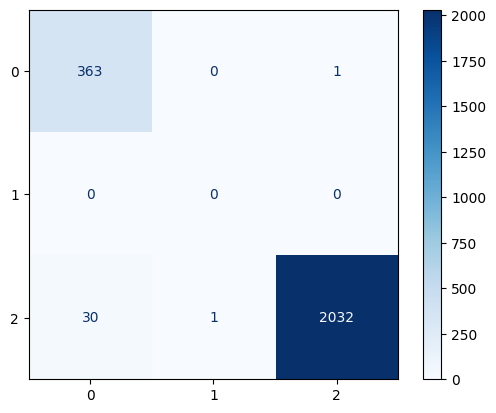

In [299]:

import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
#labeling function   
def label_cells_p5t2(row):
    if row['Cell_Cluster_level1'] == "Cancer":
        if row["Stage"] == "I":
            return "Early (Stage I/II)"
        elif row["Stage"] == "II":
            return "Early (Stage I/II)"
        elif row["Stage"] == "III":
            return "Advanced (Stage III/IV)"
    else:
        return "Non Epithelial"


z_XGB = aligned.obs.apply(label_cells_p5t2, axis=1)

class_names = ['non-Epithelial', "Non Cancer Related", "Early (Stage I/II)", "Advanced (Stage III/IV)"]

# class_names = ['non-Epithelial', "Advanced (Stage III/IV)"]



print(classification_report(aligned.obs['Classifier_predictions'], z_XGB))

print("Accuracy:", sklearn.metrics.accuracy_score(aligned.obs['Classifier_predictions'], z_XGB))

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true=z_XGB,
        y_pred=aligned.obs['Classifier_predictions'],
        display_labels=list(class_names),
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

plt.tight_layout()
plt.show()
